In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import scipy.stats as stats
from sklearn.tree import export_graphviz

In [3]:
import tslearn as ts

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

### Fitting a fixed sqrt curve to saccade data from the paper to get a function for amplitude generation

In [145]:
#equation for the velocity-amplitude curve based on main sequence
a_fs=412.256
b_fs=49.036
c_fs=5.000
popt_fs = tuple([a_fs,b_fs,c_fs])

#equation for vel-amp curve for amplitude <6 degrees
a_exp = 368.93816447
b_exp =0.49166436
c_exp = 1.48726886
popt_exp = tuple([a_exp,b_exp,c_exp])

### GENERATING EQUATION FOR MAIN SEQUENCE

In [146]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func_exp(x, a = a_exp, b = b_exp, c = c_exp):
  return a * (1 - np.exp(-(x-b)/c))
def func_sigmoid(x,a,b,c):
  return a/(1+(b/x)**c)
def func_fixsqrt(x,a = a_fs,b = b_fs,c = c_fs):
  return a + b*(x-c)**0.5

### Fitting a fixed sqrt curve to saccade data from the paper to get a function for amplitude generation

In [147]:
#equation for the velocity-amplitude curve based on main sequence
a_fs=412.256
b_fs=49.036
c_fs=5.000
popt_fs = tuple([a_fs,b_fs,c_fs])

#equation for vel-amp curve for amplitude <6 degrees
a_exp = 368.93816447
b_exp =0.49166436
c_exp = 1.48726886
popt_exp = tuple([a_exp,b_exp,c_exp])

### Laser

In [148]:
stim = [0,-7.5,0,7.5,0,7.5,-7.5,0,7.5,0,-7.5,0,7.5,0,-7.5]

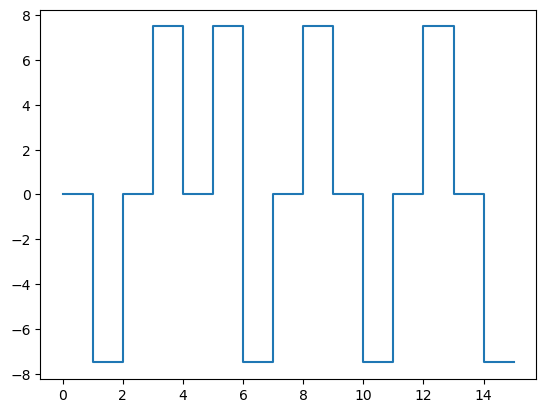

In [149]:
stimulus_rec = [0,0,-7.5,-7.5,0,0,7.5,7.5,0,0,7.5,7.5,-7.5,-7.5,0,0,7.5,7.5,0,0,-7.5,-7.5,0,0,7.5,7.5,0,0,-7.5,-7.5]
stim_time = [0,1,1,2,2,3,3,4,4,5,5,6,6,7,7,8,8,9,9,10,10,11,11,12,12,13,13,14,14,15]
plt.plot(stim_time,stimulus_rec)

### Laser

In [150]:
left = [-15, -7.5, -10, -2.5]
right = [15, 7.5, 10, 2.5]
stim_time = [0,1.259, 2.513, 3.761, 5.009, 6.263, 7.511, 8.759, 9.999,10.5]

In [151]:
#num = 1 or 2 to decide if the test starts from left side or right side
def gen_target(left,right,num):
  l2 = left
  r2 = right
  random.shuffle(l2)
  random.shuffle(r2)
  stimulus = [0]
# stimulus starts on the left side
  if num == 1:
    for i in range(len(l2)):
      stimulus.append(l2[i])
      stimulus.append(r2[i])
    stimulus.append(r2[i])
# stimulus starts on the right side
  else:
    for i in range(len(r2)):
      stimulus.append(r2[i])
      stimulus.append(l2[i])
    stimulus.append(l2[i])
  return stimulus


### Stimulus starting on left (1)

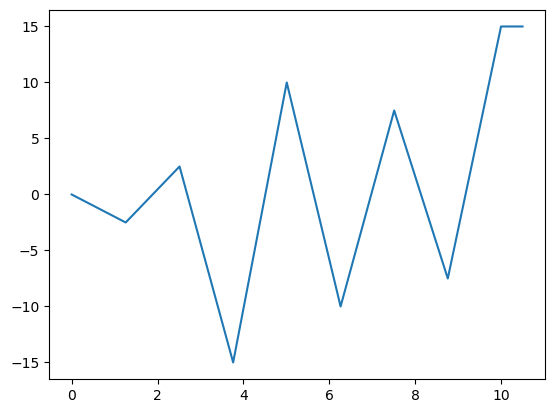

In [152]:
stimulus = gen_target(left,right,1)
plt.plot(stim_time, stimulus)

### Stimulus starting on right (not equal to 1)

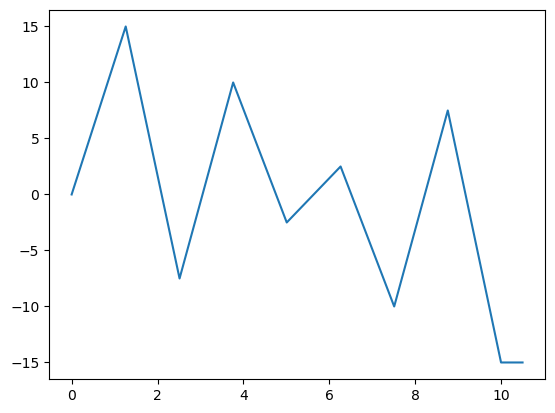

In [153]:
stimulus = gen_target(left,right,0)
plt.plot(stim_time, stimulus)

In [154]:
# duplicates every value of the stimulus
stim = stimulus[:-1]
reconstructed_laser = [val for val in stim for _ in (0, 1)]

In [155]:
reconstructed_time=[0,1.259,1.260,2.513,2.514,3.761,3.762,5.009,5.010,6.263,6.264,7.511,7.512,8.759, 8.760, 9.999,10.000,10.5]
def gen_reconstructed_laser(stimulus):
  stim = stimulus[:-1]
  reconstructed_laser = [val for val in stim for _ in (0, 1)]
  return reconstructed_laser

In [156]:
reconst_laser = gen_reconstructed_laser(stimulus)
reconstruction = pd.DataFrame([reconstructed_time,reconst_laser]).T
reconstruction.columns = ["Time","Amplitude"]
reconstruction.head()

,Time,Amplitude
0,0.000,0.0
1,1.259,0.0
2,1.260,15.0
3,2.513,15.0
4,2.514,-7.5


### Target Sequence

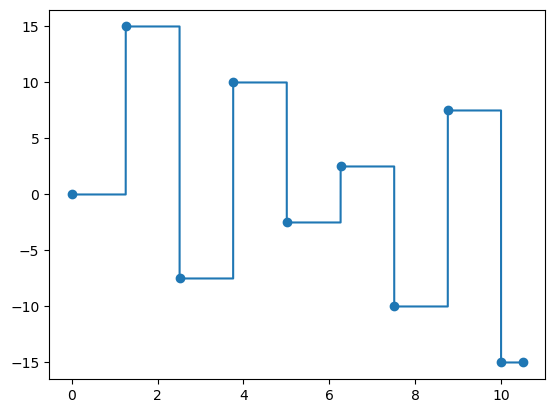

In [157]:
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.scatter(stim_time, stimulus)

## Generating the saccades


### Functions to produce latency, velocity and amplitude

In [158]:
#generate the velocity for every saccade
def gen_velocity(amplitude):
  # print("input amp", amplitude)
  amplitude = np.abs(amplitude)
  if amplitude <= 6:
      vel = func_exp(amplitude,a_exp,b_exp,c_exp)
  else:
      vel = func_fixsqrt(amplitude,a_fs,b_fs,c_fs) + np.random.uniform(0,15)*(-1)**np.random.randint(2)
  return vel

#generate the latency for a saccade for each subject
def gen_latency(subject):
    # normal subject latency parameters
    if subject == "N":
      return np.random.uniform(0.1,0.200)
    # abnormal subject latency range
    else:
      return np.random.uniform(0.1,0.2) #for a first pass we are only modeling changes in accuracy


#generate the latency for the correcting saccade
def gen_latency_correcting(subject, prev_lat):
    if subject == "N":
      return np.random.uniform(0.050,0.15)
    else:
      return np.random.uniform(0.050,0.15) #for a first pass we are only modeling changes in accuracy

#generate accuracy for the saccade
def gen_accuracy(subject, condition, sac_seq):
# normal subject accuracy range
  if subject == "N":
    if sac_seq == "P":
      # return np.random.uniform(0.70,1.20)
      return 1
    else: #correcting saccade
      return 1
# abnormal subject accuracy range
  else: #abnormal saccade
    if condition == "hyper":
    # initial shift
      if sac_seq == "P":
        return np.random.uniform(1.1,1.5) #what's the upper limit?
      else: #corrective saccade
        return np.random.uniform(1.00,1.1)
    else: #hypometria
    # initial shift
      if sac_seq == "P":
        return np.random.uniform(0.20,0.70)
      else: #corrective saccade
        return np.random.uniform(0.90,1)

### Normal Waveform - Accuracy Only

In [159]:
def gen_waveform(stimulus, subject, condition, num):
  wave = [0, 0]
  time = [0, 1]
  main_seq = []
  for idx in range(len(stimulus)-1):# Avoids out-of-range issues with stimulus[idx+1]
      # First time point: Start of the saccade (stim start + latency)
      lat = gen_latency("N")
      time.append(time[-1] + lat)  # Appends new latency time
      wave.append(wave[-1])   # Appends current stimulus level

      # print("Step 1:", time[-4:], wave[-4:])

      # Second point: First saccade amplitude
      # amplitude change
      amp = gen_accuracy(subject, condition, "P") * stimulus[idx + 1] - wave[-1]
      wave.append(amp + wave[-1])  # Amplitude added to last wave point
      # generate velocity
      vel = gen_velocity(amp)
      time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
      main_seq.append([vel,amp])
      # print("Step 2:", amp, vel, time[-4:], wave[-4:])

      # Hold the saccade
      lat2 = gen_latency_correcting(subject, lat)
      time.append(time[-1] + lat2)  # Time after latency correction
      wave.append(wave[-1])  # Holds at current amplitude
      # print("Step 3:", lat2, time[-4:], wave[-4:])

      # Third point: Corrective saccade
      amp_c = gen_accuracy(subject, condition, "C") * stimulus[idx + 1] - amp
      vel_c = gen_velocity(amp_c)
      time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
      wave.append(amp_c + amp)  # New amplitude after corrective saccade
      main_seq.append([vel_c,amp_c])
      # print("Step 4:", amp_c, amp, vel_c, time[-1], time[-4:], wave[-4:])

      # Hold the corrective saccade
      if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
          break
      final_amp = wave[-1]  # Hold at current amplitude for final correction
      time.append(stim_time[idx + 2])  # Appends the next stimulation time
      wave.append(final_amp)  # Append final amplitude
  time.append(10.5)
  wave.append(wave[-1])
      # print("Step 5:", final_amp, stim_time[idx + 2], time[-4:], wave[-4:])
  return time, wave, main_seq

Text(0.5, 1.0, 'Normal Saccade')

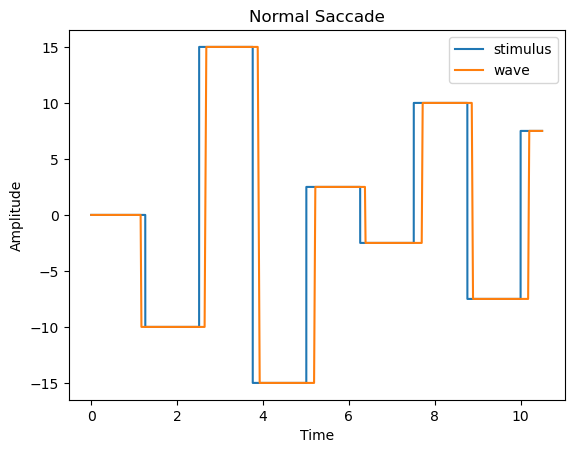

In [160]:
stimulus = gen_target(left,right,1)
time, wave, main_seq = gen_waveform(stimulus,"N","none",0)
time, wave, main_seq = gen_waveform(stimulus,"N","none",0)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.plot(time, wave)
plt.legend(["stimulus","wave"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Normal Saccade")

### Abnormal Saccade

In [161]:
#trial code
wave = [0, 0]
time = [0, 1.259]

for idx in range(len(stimulus)-1):  # Avoids out-of-range issues with stimulus[idx+1]
    # First time point: Start of the saccade (stim start + latency)
    lat = gen_latency("N")
    time.append(time[-1] + lat)  # Appends new latency time
    wave.append(wave[-1])   # Appends current stimulus level
    # print("Step 1:", time[-4:], wave[-4:])

    # Second point: First saccade amplitude
    amp = gen_accuracy("A", "hyper", "P") * stimulus[idx + 1] - wave[-1]
    wave.append(amp + wave[-1])  # Amplitude added to last wave point
    vel = gen_velocity(amp)
    time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
    # print("Step 2:", amp, vel, time[-4:], wave[-4:])

    # Hold the saccade
    lat2 = gen_latency_correcting("N", lat)
    time.append(time[-1] + lat2)  # Time after latency correction
    wave.append(wave[-1])  # Holds at current amplitude
    # print("Step 3:", lat2, time[-4:], wave[-4:])

    # Third point: Corrective saccade
    amp_c = gen_accuracy("A", "hyper", "C") * stimulus[idx + 1] - amp
    vel_c = gen_velocity(amp_c)
    time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
    wave.append(amp_c + amp)  # New amplitude after corrective saccade
    # print("Step 4:", amp_c, amp, vel_c, time[-1], time[-4:], wave[-4:])

    # Hold the corrective saccade
    if idx >= len(stimulus) - 2:  # Ensure we don’t exceed `stimulus` length
      break
    final_amp = wave[-1]  # Hold at current amplitude for final correction
    time.append(stim_time[idx + 2])  # Appends the next stimulation time
    wave.append(final_amp)  # Append final amplitude
    # print("Step 5:", final_amp, stim_time[idx + 2], time[-4:], wave[-4:])


Checking if the 'gen_waveform' function works well for abnormal saccades

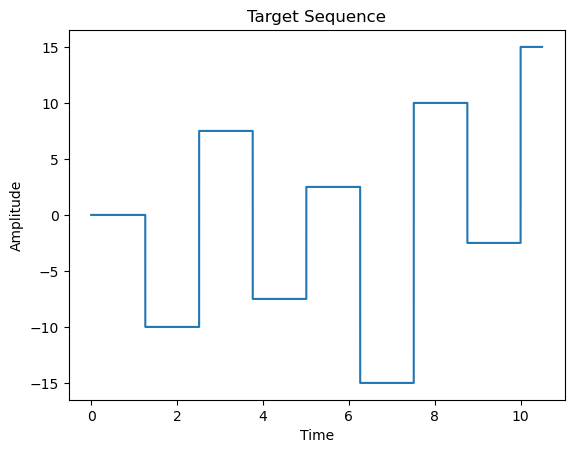

In [162]:
stimulus = gen_target(left,right,1)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title("Target Sequence")
plt.savefig("Target Seq.png")

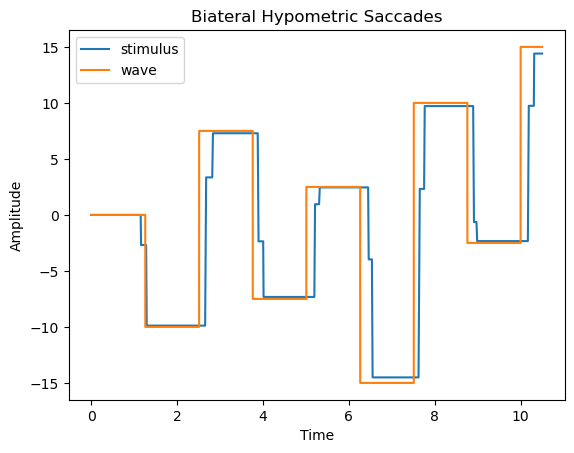

In [163]:
#hypometria
# stimulus = gen_target(left,right,1)
time, wave, main_seq = gen_waveform(stimulus,"A","hypo",3)
plt.plot(time, wave)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.legend(["stimulus","wave"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Biateral Hypometric Saccades")
plt.savefig("Hypometric.png")

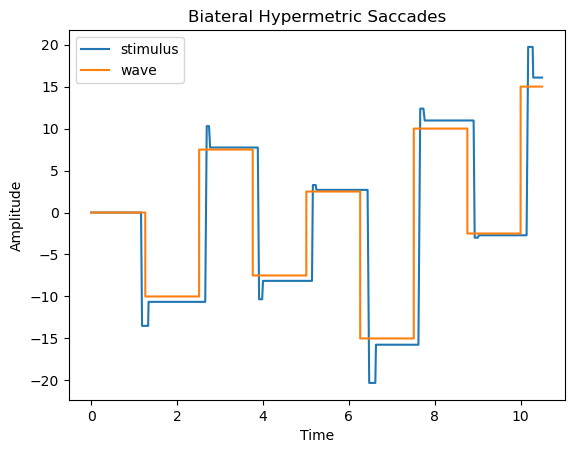

In [164]:
#hypermetria
# stimulus = gen_target(left,right,1)
time, wave, main_seq = gen_waveform(stimulus,"A","hyper",1)
plt.plot(time, wave)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.legend(["stimulus","wave"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Biateral Hypermetric Saccades")
plt.savefig("Hypermetric.png")

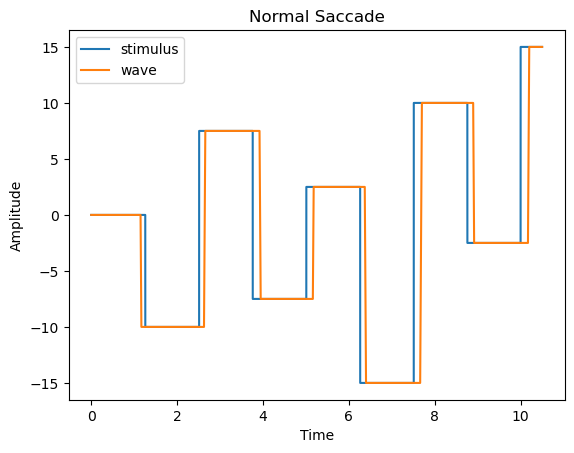

In [165]:
# stimulus = gen_target(left,right,1)
# time, wave, main_seq = gen_waveform(stimulus,"N","none",0)
time, wave, main_seq = gen_waveform(stimulus,"N","none",0)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.plot(time, wave)
plt.legend(["stimulus","wave"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Normal Saccade")
plt.savefig("Normal.png")

## Waveforms for unilateral contra and ipsi

In [166]:
def gen_unilateral(stimulus, subject, condition, num):
  wave = [0, 0]
  time = [0, 1.259]
  main_seq = []
  for idx in range(len(stimulus)-1):  # Avoids out-of-range issues with stimulus[idx+1]
    if num == 1: #generating hypers first and then hypos
        if idx % 2 ==0:
          # First time point: Start of the saccade (stim start + latency)
          lat = gen_latency(subject)
          time.append(time[-1] + lat)  # Appends new latency time
          wave.append(wave[-1])
          # print("Step 1:", time[-4:], wave[-4:])

          # Second point: First saccade amplitude
          amp = gen_accuracy(subject, "hyper", "P") * stimulus[idx + 1] - wave[-1]
          wave.append(amp + wave[-1])  # Amplitude added to last wave point
          vel = gen_velocity(amp)
          time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
          main_seq.append([vel,amp])
          # print("Step 2:", amp, vel, time[-4:], wave[-4:])

          # Hold the saccade
          lat2 = gen_latency_correcting(subject, lat)
          time.append(time[-1] + lat2)  # Time after latency correction
          wave.append(wave[-1])  # Holds at current amplitude
          # print("Step 3:", lat2, time[-4:], wave[-4:])

          # Third point: Corrective saccade
          amp_c = gen_accuracy(subject, "hyper", "C") * stimulus[idx + 1] - amp
          vel_c = gen_velocity(amp_c)
          time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
          wave.append(amp_c + amp)  # New amplitude after corrective saccade
          main_seq.append([vel_c,amp_c])
          # print("Step 4:", amp_c, amp, vel_c, time[-1], time[-4:], wave[-4:])

          # Hold the corrective saccade
          if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
              break
          final_amp = wave[-1]  # Hold at current amplitude for final correction
          time.append(stim_time[idx + 2])  # Appends the next stimulation time
          wave.append(final_amp)  # Append final amplitude

        else: #generating hypos first and then hypers
          lat = gen_latency(subject)
          time.append(time[-1] + lat)  # Appends new latency time
          wave.append(wave[-1])   # Appends current stimulus level

          # Second point: First saccade amplitude
          amp = gen_accuracy(subject, "hypo", "P") * stimulus[idx + 1] - wave[-1]
          wave.append(amp + wave[-1])  # Amplitude added to last wave point
          vel = gen_velocity(amp)
          time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
          main_seq.append([vel,amp])

          # Hold the saccade
          lat2 = gen_latency_correcting(subject, lat)
          time.append(time[-1] + lat2)  # Time after latency correction
          wave.append(wave[-1])  # Holds at current amplitude

          # Third point: Corrective saccade
          amp_c = gen_accuracy(subject, "hypo", "C") * stimulus[idx + 1] - amp
          vel_c = gen_velocity(amp_c)
          time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
          wave.append(amp_c + amp)  # New amplitude after corrective saccade
          main_seq.append([vel_c,amp_c])

          # Hold the corrective saccade
          if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
              break
          final_amp = wave[-1]  # Hold at current amplitude for final correction
          time.append(stim_time[idx + 2])  # Appends the next stimulation time
          wave.append(final_amp)  # Append final amplitude

    else:
        if idx % 2 ==1:
          # First time point: Start of the saccade (stim start + latency)
          lat = gen_latency(subject)
          time.append(time[-1] + lat)  # Appends new latency time
          wave.append(wave[-1])
          # print("Step 1:", time[-4:], wave[-4:])

          # Second point: First saccade amplitude
          amp = gen_accuracy(subject, "hyper", "P") * stimulus[idx + 1] - wave[-1]
          wave.append(amp + wave[-1])  # Amplitude added to last wave point
          vel = gen_velocity(amp)
          time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
          main_seq.append([vel,amp])
          # print("Step 2:", amp, vel, time[-4:], wave[-4:])

          # Hold the saccade
          lat2 = gen_latency_correcting(subject, lat)
          time.append(time[-1] + lat2)  # Time after latency correction
          wave.append(wave[-1])  # Holds at current amplitude
          # print("Step 3:", lat2, time[-4:], wave[-4:])

          # Third point: Corrective saccade
          amp_c = gen_accuracy(subject, "hyper", "C") * stimulus[idx + 1] - amp
          vel_c = gen_velocity(amp_c)
          time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
          wave.append(amp_c + amp)  # New amplitude after corrective saccade
          main_seq.append([vel_c,amp_c])
          # print("Step 4:", amp_c, amp, vel_c, time[-1], time[-4:], wave[-4:])

          # Hold the corrective saccade
          if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
              break
          final_amp = wave[-1]  # Hold at current amplitude for final correction
          time.append(stim_time[idx + 2])  # Appends the next stimulation time
          wave.append(final_amp)  # Append final amplitude

        else:
          lat = gen_latency(subject)
          time.append(time[-1] + lat)  # Appends new latency time
          wave.append(wave[-1])   # Appends current stimulus level

          # Second point: First saccade amplitude
          amp = gen_accuracy(subject, "hypo", "P") * stimulus[idx + 1] - wave[-1]
          wave.append(amp + wave[-1])  # Amplitude added to last wave point
          vel = gen_velocity(amp)
          time2 = time[-1] + np.abs(amp / vel)
          time.append(time[-1] + np.abs(amp / vel))  # Time for saccade based on velocity
          main_seq.append([vel,amp])

          # Hold the saccade
          lat2 = gen_latency_correcting(subject, lat)
          time.append(time[-1] + lat2)  # Time after latency correction
          wave.append(wave[-1])  # Holds at current amplitude

          # Third point: Corrective saccade
          amp_c = gen_accuracy(subject, "hypo", "C") * stimulus[idx + 1] - amp
          vel_c = gen_velocity(amp_c)
          time.append(time[-1] + np.abs(amp_c / vel_c))  # Time for corrective saccade
          wave.append(amp_c + amp)  # New amplitude after corrective saccade
          main_seq.append([vel_c,amp_c])

          # Hold the corrective saccade
          if idx >= len(stimulus) - 3:  # Ensure we don’t exceed `stimulus` length
              break
          final_amp = wave[-1]  # Hold at current amplitude for final correction
          time.append(stim_time[idx + 2])  # Appends the next stimulation time
          wave.append(final_amp)  # Append final amplitude



  time.append(10.5)
  wave.append(wave[-1])
  return time, wave, main_seq

### 4 Types of Unilaterals

### Hypo Left & Hyper Right - OMV (Left) or FOR (Right)

Text(0.5, 1.0, 'Unilateral Lesion (Hypo Left, Hyper Right)')

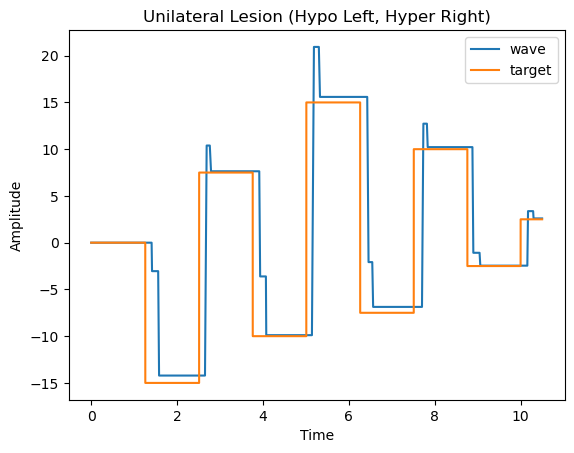

In [167]:
# unilateral
stimulus = gen_target(left,right,1)
time, wave, main_seq = gen_unilateral(stimulus,"A","unilateral",2)
plt.plot(time, wave)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.legend(["wave","target"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Unilateral Lesion (Hypo Left, Hyper Right)")

Text(0.5, 1.0, 'Unilateral Lesion (Hyper Right, Hypo Left)')

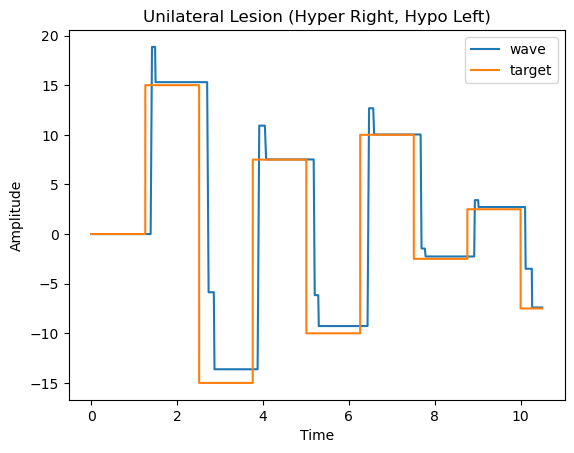

In [168]:
# unilateral
stimulus = gen_target(left,right,2)
time, wave, main_seq = gen_unilateral(stimulus,"A","unilateral",1)
plt.plot(time, wave)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.legend(["wave","target"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Unilateral Lesion (Hyper Right, Hypo Left)")

### Hyper Left & Hypo Right - OMV (Right) or FOR (Left)

Text(0.5, 1.0, 'Unilateral Lesion (Hyper Left, Hypo Right)')

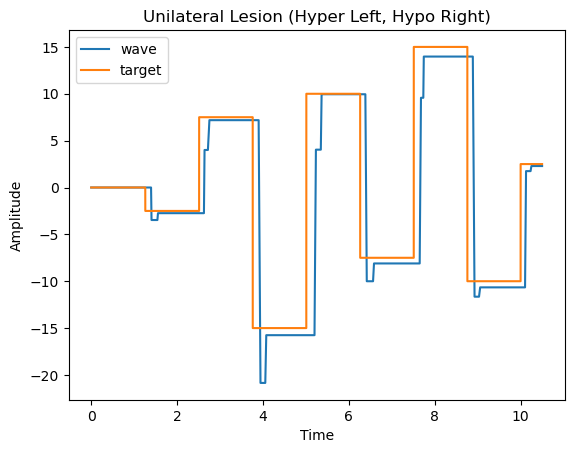

In [169]:
# stimulus starts on left
stimulus = gen_target(left,right,1)

# hypermetric first
time, wave, main_seq = gen_unilateral(stimulus,"A","unilateral",1)

plt.plot(time, wave)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.legend(["wave","target"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Unilateral Lesion (Hyper Left, Hypo Right)")

Text(0.5, 1.0, 'Unilateral Lesion (Hypo Right, Hyper Left)')

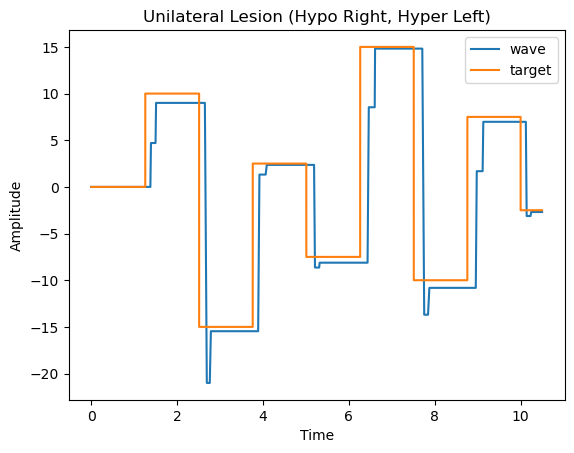

In [170]:
# stimulus starts on right
stimulus = gen_target(left,right,2)

# hypometric first
time, wave, main_seq = gen_unilateral(stimulus,"A","unilateral",2)

plt.plot(time, wave)
plt.plot(reconstructed_time,gen_reconstructed_laser(stimulus))
plt.legend(["wave","target"])
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Unilateral Lesion (Hypo Right, Hyper Left)")

### Waveform -> 1000 Hz

In [171]:
def make_df(time, waveform, samp_freq,i):
    max_t = int(10.5*samp_freq)
    timesteps = np.arange(0,max_t,1)
    wave_1000 = pd.DataFrame(data=timesteps, columns=["timesteps"]).set_index("timesteps")
    wave_df = pd.DataFrame({"timesteps": (np.array(time) * samp_freq).astype(int), f"amplitude_{i}": waveform})
    wave_df.set_index("timesteps", inplace=True)
    wave_1000 = wave_1000.join(wave_df, rsuffix=f"_{i}").interpolate(method='linear', limit_direction='both')
    wave_1000 = wave_1000.join(wave_df,on = "timesteps", rsuffix=f"_{i}")
    return wave_1000

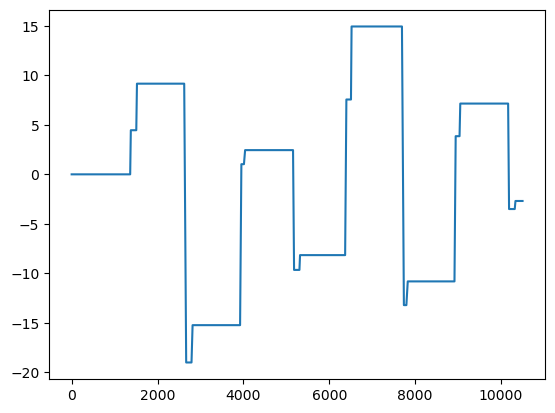

In [172]:
time, wave, main_seq = gen_unilateral(stimulus,"A","unilateral",2)
df = make_df(time,wave,1000,0)
timesteps = list(range(0,10500))
amp = df['amplitude_0']
plt.plot(timesteps,amp)

### 1 second = 1000 points

In [173]:
timesteps = np.arange(0,10500,1)

In [174]:
stimulus = gen_target(left,right,1)
# target sequence
reconstructed_laser = gen_reconstructed_laser(stimulus)
stimulus_df = make_df(reconstructed_time,reconstructed_laser,1000,0)
stimulus_1000 = pd.DataFrame(index=timesteps)
stimulus_1000 = stimulus_1000.reset_index()
stimulus_1000.rename(columns = {'index':'timesteps'},inplace = True)
stimulus_1000 = stimulus_1000.join(stimulus_df,on = "timesteps").interpolate(method='linear', limit_direction='both')
stimulus_1000.rename(columns = {'amplitude_0':'amplitude'},inplace = True)
stimulus_1000.shape

(10500, 3)

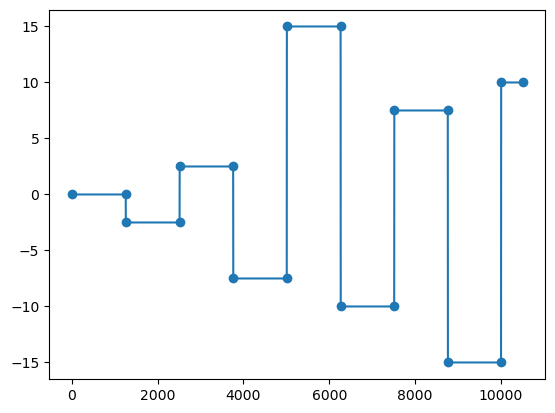

In [175]:
#checking if the 1000Hz stimulus looks good

plt.plot(stimulus_1000.index,stimulus_1000.amplitude)
t = [x*1000 for x in reconstructed_time]
plt.scatter(t,reconstructed_laser)

### 1 second equals 60 points

In [176]:
max_t = int(10.5*60)
timesteps = np.arange(0,max_t,1)
stimulus = gen_target(left,right,1)
reconstructed_laser = gen_reconstructed_laser(stimulus)
stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
stimulus_60 = pd.DataFrame(index=timesteps)
stimulus_60 = stimulus_60.reset_index()
stimulus_60.rename(columns = {'index':'timesteps'},inplace = True)
stimulus_60 = stimulus_60.join(stimulus_df,on = "timesteps").interpolate(method='linear', limit_direction='both')
stimulus_60.rename(columns = {'amplitude_0':'amplitude'},inplace = True)
stimulus_60

,timesteps,amplitude,amplitude_0_0
0,0,0.0,0.0
1,1,0.0,0.0
2,2,0.0,0.0
3,3,0.0,0.0
4,4,0.0,0.0
...,...,...,...
625,625,2.5,2.5
626,626,2.5,2.5
627,627,2.5,2.5
628,628,2.5,2.5


### Generate Tuples Frome Dataset of Interest - Equal Class Sizes

In [177]:
def tuple_generation(data_size):
    
    g_size = int(data_size/6)
    class_size = g_size * 2
    
    # Create a tuple of tuples
    # normal class - vary start stimulus direction
    x_input_normal_1 = tuple(("N", "none",1) for _ in range(g_size))
    x_input_normal_2 = tuple(("N", "none",2) for _ in range(g_size))

    # bilateral hypometric class - vary start stimulus direction
    x_input_hypo_1 = tuple(("A", "hypo",1) for _ in range(g_size))
    x_input_hypo_2 = tuple(("A", "hypo",2) for _ in range(g_size))

    # bilateral hypermetric class - vary start stimulus direction
    x_input_hyper_1 = tuple(("A", "hyper",1) for _ in range(g_size))
    x_input_hyper_2 = tuple(("A", "hyper",2) for _ in range(g_size))
    
    x_input_list_one = [x_input_normal_1,x_input_normal_2,x_input_hypo_1,x_input_hypo_2,
    x_input_hyper_1,x_input_hyper_2]
    
    # hypos on right & hypers on left
    # 1: stimulus starts on the left
    # 1: hypers are first
    x_input_uni_1_1 = tuple(("A", "unilateral",1,1) for _ in range(g_size))
    # stimulus starts on right
    x_input_uni_2_2 = tuple(("A", "unilateral",2,2) for _ in range(g_size))

    # hypers on right & hypos on left
    # stimulus start on left
    x_input_uni_1_2 = tuple(("A", "unilateral",1,2) for _ in range(g_size))
    # stimulus starts on right
    x_input_uni_2_1 = tuple(("A", "unilateral",2,1) for _ in range(g_size))
    
    y_list = np.concatenate(([0]*class_size, [1]*class_size, 
    [2]*class_size,[3]*class_size, [4]*class_size))
    
    return x_input_normal_1, x_input_normal_2, x_input_hypo_1,x_input_hypo_2,x_input_hyper_1,x_input_hyper_2

In [201]:
x_input_normal_1, x_input_normal_2, x_input_hypo_1,x_input_hypo_2,x_input_hyper_1,x_input_hyper_2 = tuple_generation(3000)

In [202]:
normals = [x_input_normal_1,x_input_normal_2]
hypos = [x_input_hypo_1,x_input_hypo_2]
hypers = [x_input_hyper_1,x_input_hyper_2]

### Data Generation

In [203]:
for i, row in enumerate(x_input_normal_1):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    filename = f"normal_1_{i}.csv"
    first_five_sec.to_csv(filename,index = False)

In [206]:
for i, row in enumerate(x_input_normal_2):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    filename = f"normal_2_{i}.csv"
    first_five_sec.to_csv(filename,index = False)

In [212]:
for i, row in enumerate(x_input_hypo_1):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    filename = f"hypo_1_{i}.csv"
    first_five_sec.to_csv(filename,index = False)

In [215]:
for i, row in enumerate(x_input_hypo_2):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    filename = f"hypo_2_{i}.csv"
    first_five_sec.to_csv(filename,index = False)

In [218]:
for i, row in enumerate(x_input_hyper_1):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    filename = f"hyper_1_{i}.csv"
    first_five_sec.to_csv(filename,index = False)

In [224]:
for i, row in enumerate(x_input_hyper_2):
    target = []
    data = []
    
    # generate stimulus
    stimulus = gen_target(left,right,row[2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:]
    
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
        
    data.append(wave_df.T.values[:-1])
    # if i % 1000 == 0:
        # print("we're going strong..")
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    filename = f"hyper_2_{i}.csv"
    first_five_sec.to_csv(filename,index = False)

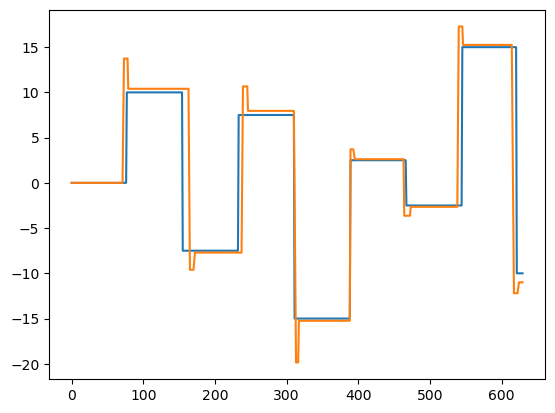

In [225]:
full_data
plt.plot(full_data['timesteps'],full_data['target'])
plt.plot(full_data['timesteps'],full_data['patient'])

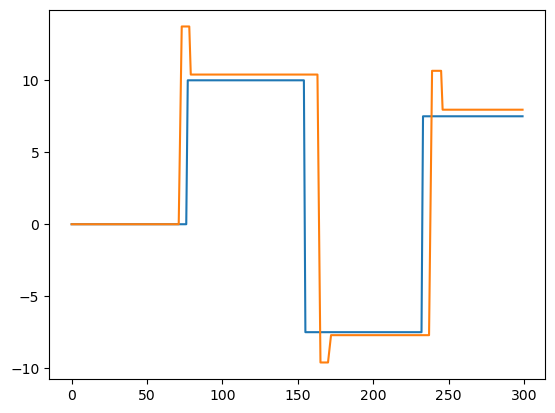

In [226]:
first_five_sec
plt.plot(first_five_sec['timesteps'],first_five_sec['target'])
plt.plot(first_five_sec['timesteps'],first_five_sec['patient'])

In [136]:
# target = []
# data = []
for i, row in enumerate(normals):
    target = []
    data = []
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    reconstructed_laser = gen_reconstructed_laser(stimulus)
    # stimulus dataframe
    stimulus_df = make_df(reconstructed_time,reconstructed_laser,60,0)
    stimulus_df = stimulus_df.iloc[:630,:-1]
    target.append(stimulus_df.T.values[0])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,60,i)
    wave_df = wave_df.iloc[:630,:-1]
    if(len(wave_df.T.values[0]) != 630):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    
    target = target[0]
    patient = data[0][0]
    timesteps = list(range(0,630))
    full_data = pd.DataFrame({'timesteps':timesteps,'target':target,'patient':patient})
    first_five_sec = full_data.iloc[:300,:]
    filename = f"normal_{i}.csv"
    first_five_sec.to_csv(filename,index = False)
    
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")


IndexError: tuple index out of range

### Normal Waveforms

In [130]:
x_input_list_one

[(('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),
  ('N', 'none', 1),


In [52]:
data = []
num_classes = len(x_input_list_one)

for i in range(0,num_classes):
    for j, row in enumerate(x_input_list_one[i]):
        # generate stimulus
        stimulus = gen_target(left,right,row[2])
        time, waveform, main_seq = gen_waveform(stimulus, *row)
        wave_df = make_df(time, waveform,60,j)
        wave_df = wave_df.iloc[:10.5*60,:]
        if(len(wave_df.T.values[0]) != 10.5*60):
            print("What the hell")
            print(i)
            print(len(wave_df.T.values[0]))
        data.append(wave_df.T.values[:-1])
        # if i % 1000 == 0:
            # print("we're going strong..")

for i, row in enumerate(x_input_uni_1_1):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

for i, row in enumerate(x_input_uni_2_2):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

for i, row in enumerate(x_input_uni_1_2):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

for i, row in enumerate(x_input_uni_2_1):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

we're going strong..
we're going strong..
we're going strong..
we're going strong..


In [53]:
transformed = np.array(data)
num_waves = np.shape(np.array(data))[0]
new = transformed.reshape(num_waves,10500)
wave_1000 = pd.DataFrame(new).T
wave_1000

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,7.5,15.0,15.0,2.5,10.0,15.0,2.5,15.0,2.5,2.5,...,-9.238785,-7.32592,-9.625364,-9.345644,-2.485754,-7.30029,-9.483487,-2.42592,-14.40475,-9.131127
10496,7.5,15.0,15.0,2.5,10.0,15.0,2.5,15.0,2.5,2.5,...,-9.238785,-7.32592,-9.625364,-9.345644,-2.485754,-7.30029,-9.483487,-2.42592,-14.40475,-9.131127
10497,7.5,15.0,15.0,2.5,10.0,15.0,2.5,15.0,2.5,2.5,...,-9.238785,-7.32592,-9.625364,-9.345644,-2.485754,-7.30029,-9.483487,-2.42592,-14.40475,-9.131127
10498,7.5,15.0,15.0,2.5,10.0,15.0,2.5,15.0,2.5,2.5,...,-9.238785,-7.32592,-9.625364,-9.345644,-2.485754,-7.30029,-9.483487,-2.42592,-14.40475,-9.131127


In [59]:
wave_500 = wave_1000[wave_1000.index % 2 != 0]  # Excludes every 2nd row starting from 0
wave_250 = wave_500[::2]  # Excludes every 2nd row starting from 0
wave_125 = wave_250[::2]  # Excludes every 2nd row starting from 0
wave_63 = wave_125[::2]
wave_32 = wave_63[::2]
wave_16 = wave_32[::2]

In [60]:
def num_generator(cl, num_points):
    if(cl.upper() == "N1"):
        upper_bound = int(num_points/10)
        num = upper_bound-3
    if(cl.upper() == "N2"):
        upper_bound = int(2 * num_points/10)
        num = upper_bound-3
    if(cl.upper() == "BHYPO1"):
        upper_bound = int(3 * num_points/10)
        num = upper_bound-3
    if(cl.upper() == "BHYPO2"):
        upper_bound = int(4 * num_points/10)
        num = upper_bound-3
    if(cl.upper() == "BHYPER1"):
        upper_bound = int(5 * num_points/10)
        num = upper_bound-3
    if(cl.upper() == "BHYPER2"):
        upper_bound = int(6 * num_points/10)
        num = upper_bound-3
    if(cl.upper() == "UNI_1_1"):
        upper_bound = int(7 * num_points/10)
        num = upper_bound-3
    if(cl.upper() == "UNI_1_2"):
        upper_bound = int(8 * num_points/10)
        num = upper_bound-3
    if(cl.upper() == "UNI_2_1"):
        upper_bound = int(9 * num_points/10)
        num = upper_bound-3
    if(cl.upper() == "UNI_2_2"):
        upper_bound = int(10 * num_points/10)
        num = upper_bound-3
    
    return num

In [61]:
def plot_waveform(cl, num_points, freq):
    num = num_generator(cl, num_points)
    print(num)
    fig, axs = plt.subplots(1,2,figsize = (12,5))
    if(freq == 1000):
        axs[0].scatter(wave_1000.index,wave_1000.iloc[:,num])
        axs[0].set_title("1000 Hz " + cl.upper() + " Waveform (Scatter)")
        axs[1].plot(wave_1000.index,wave_1000.iloc[:,num])
        axs[1].set_title("1000 Hz " + cl.upper() + " Waveform")
    elif(freq == 500):
        axs[0].scatter(wave_500.index,wave_500.iloc[:,num])
        axs[0].set_title("500 Hz " + cl.upper() + " Waveform (Scatter)")
        axs[1].plot(wave_500.index,wave_500.iloc[:,num])
        axs[1].set_title("500 Hz " + cl.upper() + " Waveform")
    elif(freq == 250):
        axs[0].scatter(wave_250.index,wave_250.iloc[:,num])
        axs[0].set_title("250 Hz " + cl.upper() + " Waveform (Scatter)")
        axs[1].plot(wave_250.index,wave_250.iloc[:,num])
        axs[1].set_title("250 Hz " + cl.upper() + " Waveform")
    elif(freq == 125):
        axs[0].scatter(wave_125.index,wave_125.iloc[:,num])
        axs[0].set_title("125 Hz " + cl.upper() + " Waveform (Scatter)")
        axs[1].plot(wave_125.index,wave_125.iloc[:,num])
        axs[1].set_title("125 Hz " + cl.upper() + " Waveform")
    elif(freq == 63):
        axs[0].scatter(wave_63.index,wave_63.iloc[:,num])
        axs[0].set_title("63 Hz " + cl.upper() + " Waveform (Scatter)")
        axs[1].plot(wave_63.index,wave_63.iloc[:,num])
        axs[1].set_title("63 Hz " + cl.upper() + " Waveform")
    elif(freq == 32):
        axs[0].scatter(wave_32.index,wave_32.iloc[:,num])
        axs[0].set_title("32 Hz " + cl.upper() + " Waveform (Scatter)")
        axs[1].plot(wave_32.index,wave_32.iloc[:,num])
        axs[1].set_title("32 Hz " + cl.upper() + " Waveform")
    elif(freq == 16):
        axs[0].scatter(wave_16.index,wave_16.iloc[:,num])
        axs[0].set_title("16 Hz " + cl.upper() + " Waveform (Scatter)")
        axs[1].plot(wave_16.index,wave_16.iloc[:,num])
        axs[1].set_title("16 Hz " + cl.upper() + " Waveform")

497


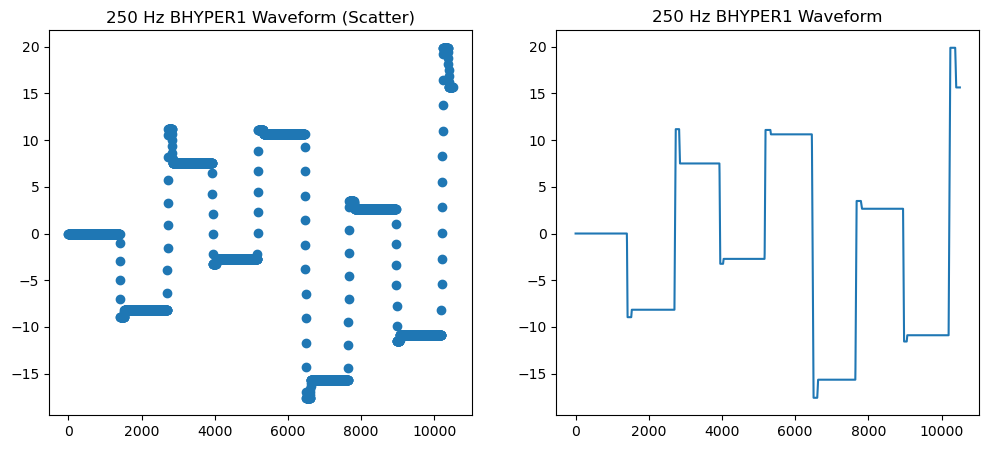

In [62]:
plot_waveform("bhyper1",1000,250)

### Comparing the 1000 Hz waveform to downsampled version

(1700.0, 2000.0)

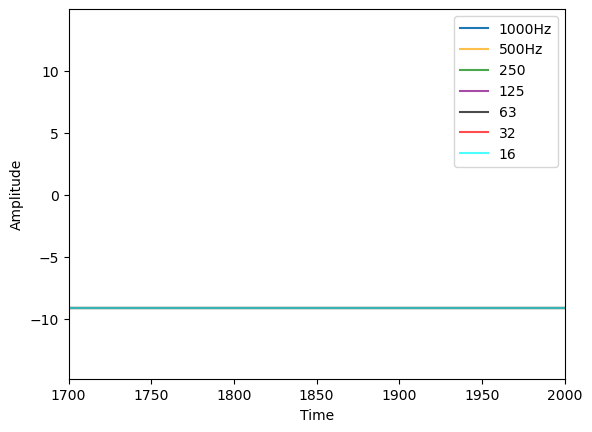

In [122]:
plt.plot(timesteps, wave_1000.iloc[:,201])
plt.plot(wave_500.index, wave_500.iloc[:,201], c = "orange",alpha = 0.7)
plt.plot(wave_250.index, wave_250.iloc[:,201], c = "green",alpha = 0.7)
plt.plot(wave_125.index, wave_125.iloc[:,201], c = "purple",alpha = 0.7)
plt.plot(wave_63.index, wave_63.iloc[:,201], c = "black",alpha = 0.7)
plt.plot(wave_32.index, wave_32.iloc[:,201], c = "red",alpha = 0.7)
plt.plot(wave_16.index, wave_16.iloc[:,201], c = "cyan",alpha = 0.7)

plt.xlabel("Time")
plt.ylabel("Amplitude")
# plt.legend(["1000Hz","500Hz","250Hz","125Hz"])
plt.legend(["1000Hz","500Hz","250","125","63","32","16"])
plt.xlim(1700,2000)

(1700.0, 2000.0)

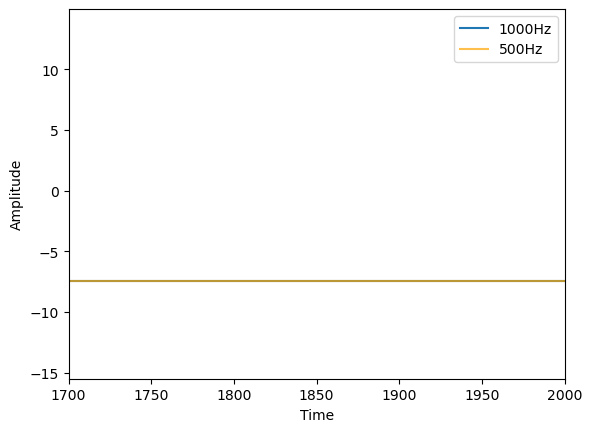

In [125]:
plt.plot(timesteps, wave_1000.iloc[:,203])
plt.plot(wave_500.index, wave_500.iloc[:,203], c = "orange",alpha = 0.7)
plt.xlabel("Time")
plt.ylabel("Amplitude")
# plt.legend(["1000Hz","500Hz","250Hz","125Hz"])
plt.legend(["1000Hz","500Hz"])
plt.xlim(1700,2000)

(1700.0, 2000.0)

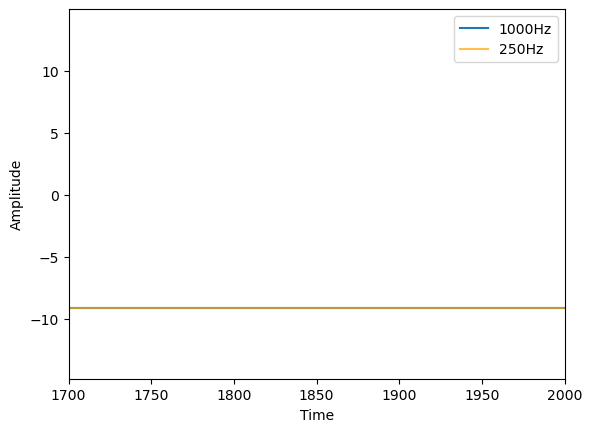

In [126]:
plt.plot(timesteps, wave_1000.iloc[:,201])
plt.plot(wave_250.index, wave_250.iloc[:,201], c = "orange",alpha = 0.7)
plt.xlabel("Time")
plt.ylabel("Amplitude")
# plt.legend(["1000Hz","500Hz","250Hz","125Hz"])
plt.legend(["1000Hz","250Hz"])
plt.xlim(1700,2000)

(1700.0, 2000.0)

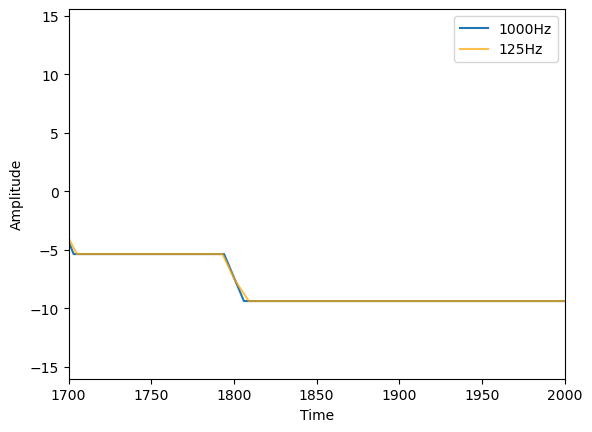

In [64]:
plt.plot(timesteps, wave_1000.iloc[:,201])
plt.plot(wave_125.index, wave_125.iloc[:,201], c = "orange",alpha = 0.7)
plt.xlabel("Time")
plt.ylabel("Amplitude")
# plt.legend(["1000Hz","500Hz","250Hz","125Hz"])
plt.legend(["1000Hz","125Hz"])
plt.xlim(1700,2000)

(1700.0, 2000.0)

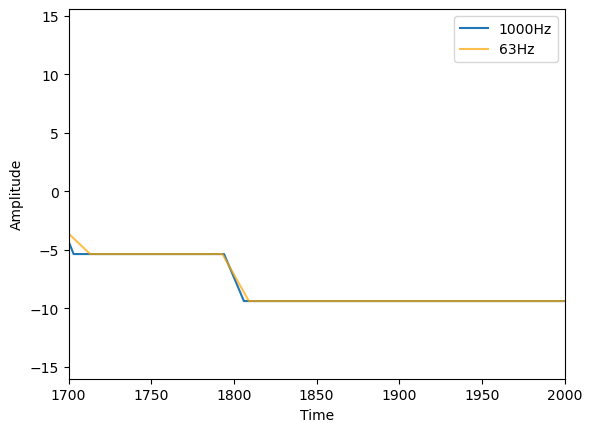

In [65]:
plt.plot(timesteps, wave_1000.iloc[:,201])
plt.plot(wave_63.index, wave_63.iloc[:,201], c = "orange",alpha = 0.7)
plt.xlabel("Time")
plt.ylabel("Amplitude")
# plt.legend(["1000Hz","500Hz","250Hz","125Hz"])
plt.legend(["1000Hz","63Hz"])
plt.xlim(1700,2000)

(1700.0, 2000.0)

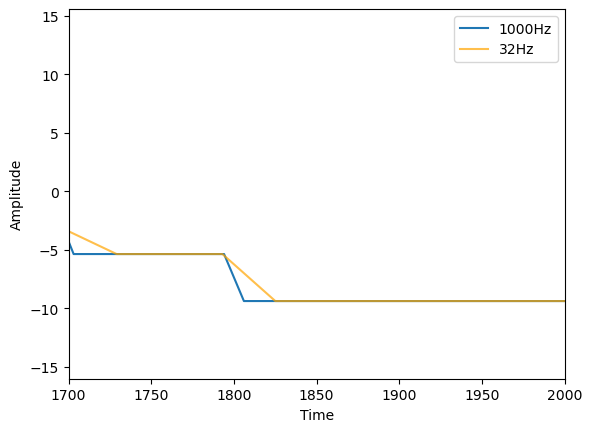

In [66]:
plt.plot(timesteps, wave_1000.iloc[:,201])
plt.plot(wave_32.index, wave_32.iloc[:,201], c = "orange",alpha = 0.7)
plt.xlabel("Time")
plt.ylabel("Amplitude")
# plt.legend(["1000Hz","500Hz","250Hz","125Hz"])
plt.legend(["1000Hz","32Hz"])
plt.xlim(1700,2000)

(1700.0, 2000.0)

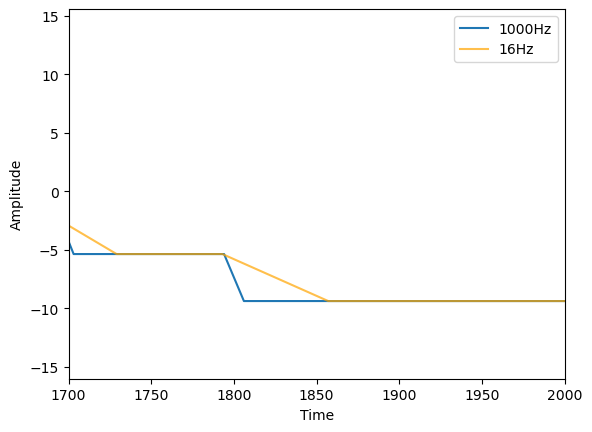

In [67]:
plt.plot(timesteps, wave_1000.iloc[:,201])
plt.plot(wave_16.index, wave_16.iloc[:,201], c = "orange",alpha = 0.7)
plt.xlabel("Time")
plt.ylabel("Amplitude")
# plt.legend(["1000Hz","500Hz","250Hz","125Hz"])
plt.legend(["1000Hz","16Hz"])
plt.xlim(1700,2000)

## ttt

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

In [1]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

NameError: name 'tf' is not defined

In [328]:
X = wave_1000.T.values
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

(1000, 10500, 1)

In [330]:
# Labels: 0 - normal, 1 - hypometria, 2 - hypermetria
y = to_categorical(y_list)  # Convert to one-hot encoding
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [332]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify = y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (700, 10500, 1), y_train shape: (700, 5)
X_test shape: (300, 10500, 1), y_test shape: (300, 5)


In [334]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(10500,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 5s 216ms/step - accuracy: 0.2575 - loss: 10.4649 - val_accuracy: 0.3286 - val_loss: 1.4187
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 212ms/step - accuracy: 0.3300 - loss: 1.4185 - val_accuracy: 0.3786 - val_loss: 1.3826
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 215ms/step - accuracy: 0.4154 - loss: 1.3319 - val_accuracy: 0.4071 - val_loss: 1.3540
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 210ms/step - accuracy: 0.4427 - loss: 1.3108 - val_accuracy: 0.3929 - val_loss: 1.2698
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 207ms/step - accuracy: 0.4787 - loss: 1.2537 - val_accuracy: 0.6000 - val_loss: 1.1375
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 205ms/step - accuracy: 0.5175 - loss: 1.1163 - val_accuracy: 0.6500 - val_loss: 1.0444
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 209ms/step - accuracy: 0.5305 - loss: 1.0290 - val_accuracy: 0.5643 - val_loss: 0.9582
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 4s 217ms/step - accuracy: 0.5765 - loss: 0.9919 - val_accuracy: 0

10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step


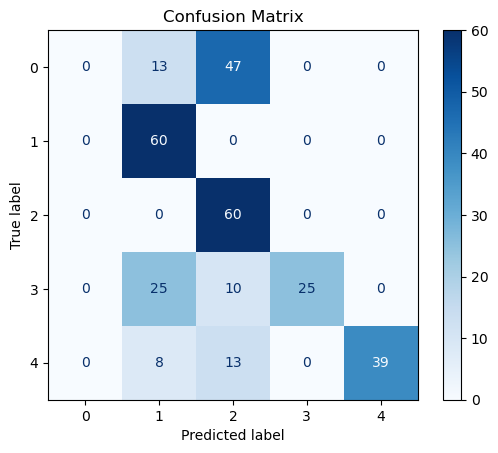

In [340]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [342]:
fname_1000_1000_3 = 'weights-Test-CNN.1000_1000_3.weights.h5'
model.save_weights(fname_1000_1000_3, overwrite = True)

### ALL DATA in the Normal Class

In [ ]:
zero_indices = np.where(y_true == 0)
true_zero_indices = zero_indices[0]

In [ ]:
true_pred = np.where(pred_values == 0)[0]
false_pred_ones = np.where(pred_values == 1)[0]
false_pred_twos = np.where(pred_values == 2)[0]
false_pred_threes = np.where(pred_values == 3)[0]
false_pred_fours = np.where(pred_values == 4)[0]

In [ ]:
tpredind_one = true_zero_indices[true_pred]
fpredind_one = true_zero_indices[false_pred_ones]
fpredind_two = true_zero_indices[false_pred_twos]
fpredind_threes = true_zero_indices[false_pred_threes]
fpredind_fours = true_zero_indices[false_pred_fours]

In [ ]:
true_0_0 = X_test[tpredind_one]
false_0_1 = X_test[fpredind_one]
false_0_2 = X_test[fpredind_two]
false_0_3 = X_test[fpredind_threes]
false_0_4 = X_test[fpredind_fours]

### 2 Layer Run

In [344]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(10500,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))


# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 152ms/step - accuracy: 0.2486 - loss: 33.2757 - val_accuracy: 0.3000 - val_loss: 1.5574
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/step - accuracy: 0.2771 - loss: 1.8420 - val_accuracy: 0.3357 - val_loss: 1.4077
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.4100 - loss: 1.3276 - val_accuracy: 0.4000 - val_loss: 1.3906
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.3986 - loss: 1.3221 - val_accuracy: 0.3643 - val_loss: 1.3360
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 142ms/step - accuracy: 0.3887 - loss: 1.3021 - val_accuracy: 0.4143 - val_loss: 1.2954
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 143ms/step - accuracy: 0.4388 - loss: 1.2558 - val_accuracy: 0.4357 - val_loss: 1.2636
Epoch 7/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 144ms/step - accuracy: 0.5069 - loss: 1.1773 - val_accuracy: 0.4643 - val_loss: 1.1991
Epoch 8/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.4182 - loss: 1.2095 - val_accuracy: 0.6000 - val

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


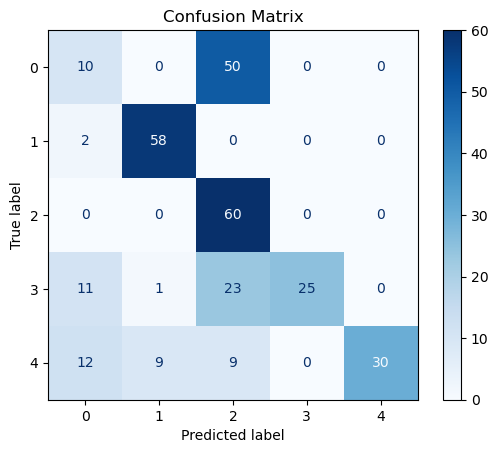

In [346]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [348]:
fname_1000_1000_2 = 'weights-Test-CNN.1000_1000_2.weights.h5'
model.save_weights(fname_1000_1000_2, overwrite = True)

### 1 Layer Run

In [ ]:
# Define the 1D CNN Model

model = Sequential()

# Add 1 convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(10500,1)))
model.add(MaxPooling1D(pool_size=2))


# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
fname_1000_1000_1 = 'weights-Test-CNN.1000_1000_1.weights.h5'
model.save_weights(fname_1000_1000_1, overwrite = True)

### 500 Hz Model Run

### 3 Layers

In [ ]:
X = wave_500.T.values
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify = y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

In [ ]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(5250,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
fname_1000_500_3 = 'weights-Test-CNN.1000_1000_1.weights.h5'
model.save_weights(fname_1000_500_3, overwrite = True)

### 2 Layers

In [ ]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(5250,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
fname_1000_500_2 = 'weights-Test-CNN.1000_1000_1.weights.h5'
model.save_weights(fname_1000_500_2, overwrite = True)

### 1 Layer

In [ ]:
# Define the 1D CNN Model

model = Sequential()

# Add 1 convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(5250,1)))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
fname_1000_500_1 = 'weights-Test-CNN.1000_1000_1.weights.h5'
model.save_weights(fname_1000_500_1, overwrite = True)

### 250 Hz Run

In [ ]:
X = wave_250.T.values
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify = y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

### 3 Layers

In [ ]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1750,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
fname_1000_250_3 = 'weights-Test-CNN.1000_1000_1.weights.h5'
model.save_weights(fname_1000_250_3, overwrite = True)

### 2 Layers

In [ ]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1750,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
fname_1000_250_2 = 'weights-Test-CNN.1000_1000_1.weights.h5'
model.save_weights(fname_1000_250_2, overwrite = True)

### 1 Layer

In [ ]:
# Define the 1D CNN Model

model = Sequential()

# Add 1 convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1750,1)))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

In [ ]:
fname_1000_250_1 = 'weights-Test-CNN.1000_1000_1.weights.h5'
model.save_weights(fname_1000_250_1, overwrite = True)

### Generate 4000 of each class

In [315]:
# Create a tuple of tuples

# normal class
x_input_normal_1 = tuple(("N", "none",1) for _ in range(2000))
x_input_normal_2 = tuple(("N", "none",2) for _ in range(2000))

# bilateral hypometric class
x_input_hypo_1 = tuple(("A", "hypo",1) for _ in range(2000))
x_input_hypo_2 = tuple(("A", "hypo",2) for _ in range(2000))

# bilateral hypermetric class
x_input_hyper_1 = tuple(("A", "hyper",1) for _ in range(2000))
x_input_hyper_2 = tuple(("A", "hyper",2) for _ in range(2000))

x_input_list_one = np.concatenate((x_input_normal_1,x_input_normal_2,x_input_hypo_1,x_input_hypo_2,x_input_hyper_1,x_input_hyper_2))

In [317]:
# hypos on right & hypers on left
x_input_uni_1_1 = tuple(("A", "unilateral",1,1) for _ in range(2000))
x_input_uni_2_2 = tuple(("A", "unilateral",2,2) for _ in range(2000))

# hypers on right & hypos on left
x_input_uni_1_2 = tuple(("A", "unilateral",1,2) for _ in range(2000))
x_input_uni_2_1 = tuple(("A", "unilateral",2,1) for _ in range(2000))

In [319]:
#0 -> normal, 1-> bilateral hypo, 2 -> bilateral hyper, 3 -> hypo right & hyper left, 4 -> hyper right & hypo left
y_list = np.concatenate(([0]*4000, [1]*4000, [2]*4000,[3]*4000, [4]*4000))

In [321]:
wave_merged = pd.DataFrame(data=timesteps, columns=["timesteps"]).set_index("timesteps")
merged_wave = []
stim_df = pd.DataFrame(data=stim_time, columns=["timesteps"])
tensor_combined = torch.empty(0)
stim_combined = torch.empty(0)
mainseq_combined = torch.empty(0)
data = []

for i, row in enumerate(x_input_list_one):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    time, waveform, main_seq = gen_waveform(stimulus, *row)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values[:-1])
    if i % 1000 == 0:
        print("we're going strong..")

for i, row in enumerate(x_input_uni_1_1):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

for i, row in enumerate(x_input_uni_2_2):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

for i, row in enumerate(x_input_uni_1_2):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

for i, row in enumerate(x_input_uni_2_1):
    # generate stimulus
    stimulus = gen_target(left,right,row[-2])
    saccade_pattern = row[-1]
    time, waveform, main_seq = gen_unilateral(stimulus, *row[:-2], saccade_pattern)
    wave_df = make_df(time, waveform,i)
    wave_df = wave_df.iloc[:10500,:-1]
    if(len(wave_df.T.values[0]) != 10500):
        print("What the hell")
        print(i)
        print(len(wave_df.T.values[0]))
    data.append(wave_df.T.values)
    # generate waveform
    if i % 1000 == 0:
        print("we're going strong..")

we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..
we're going strong..


In [325]:
transformed = np.array(data)
num_waves = np.shape(np.array(data))[0]
new = transformed.reshape(num_waves,10500)
wave_1000 = pd.DataFrame(new).T
wave_1000

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10495,-15.0,-7.5,-7.5,-10.0,-10.0,-15.0,-10.0,-7.5,-10.0,-2.5,...,-2.357614,-9.139682,-2.431487,-9.207276,-7.279334,-7.149963,-2.364232,-7.326982,-2.48715,-7.175452
10496,-15.0,-7.5,-7.5,-10.0,-10.0,-15.0,-10.0,-7.5,-10.0,-2.5,...,-2.357614,-9.139682,-2.431487,-9.207276,-7.279334,-7.149963,-2.364232,-7.326982,-2.48715,-7.175452
10497,-15.0,-7.5,-7.5,-10.0,-10.0,-15.0,-10.0,-7.5,-10.0,-2.5,...,-2.357614,-9.139682,-2.431487,-9.207276,-7.279334,-7.149963,-2.364232,-7.326982,-2.48715,-7.175452
10498,-15.0,-7.5,-7.5,-10.0,-10.0,-15.0,-10.0,-7.5,-10.0,-2.5,...,-2.357614,-9.139682,-2.431487,-9.207276,-7.279334,-7.149963,-2.364232,-7.326982,-2.48715,-7.175452


In [327]:
wave_500 = wave_1000[wave_1000.index % 2 != 0]  # Excludes every 2nd row starting from 0
wave_250 = wave_500[::3]  # Excludes every 2nd row starting from 0
wave_125 = wave_250[::2]  # Excludes every 2nd row starting from 0

### CNN Model Testing - 1000 Hz

In [328]:
X = wave_1000.T.values
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

(20000, 10500, 1)

In [331]:
# Labels: 0 - normal, 1 - hypometria, 2 - hypermetria
y = to_categorical(y_list)  # Convert to one-hot encoding
y

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]])

In [333]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify = y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (14000, 10500, 1), y_train shape: (14000, 5)
X_test shape: (6000, 10500, 1), y_test shape: (6000, 5)


### 3 Layers

In [336]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(10500,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 74s 210ms/step - accuracy: 0.3506 - loss: 3.9820 - val_accuracy: 0.5743 - val_loss: 1.1229
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 77s 218ms/step - accuracy: 0.4760 - loss: 1.1806 - val_accuracy: 0.6746 - val_loss: 1.0124
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 78s 224ms/step - accuracy: 0.5089 - loss: 1.1156 - val_accuracy: 0.7582 - val_loss: 0.9316
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 81s 232ms/step - accuracy: 0.5205 - loss: 1.0836 - val_accuracy: 0.6418 - val_loss: 0.9729
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 80s 228ms/step - accuracy: 0.5189 - loss: 1.1086 - val_accuracy: 0.7711 - val_loss: 0.8722
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 79s 227ms/step - accuracy: 0.5383 - loss: 1.0805 - val_accuracy: 0.7507 - val_loss: 0.8357
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 83s 235ms/step - accuracy: 0.5361 - loss: 1.0791 - val_accuracy: 0.7793 - val_loss: 0.8632
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 82s 235ms/step - accuracy: 0.5501 - loss: 1

188/188 ━━━━━━━━━━━━━━━━━━━━ 9s 48ms/step


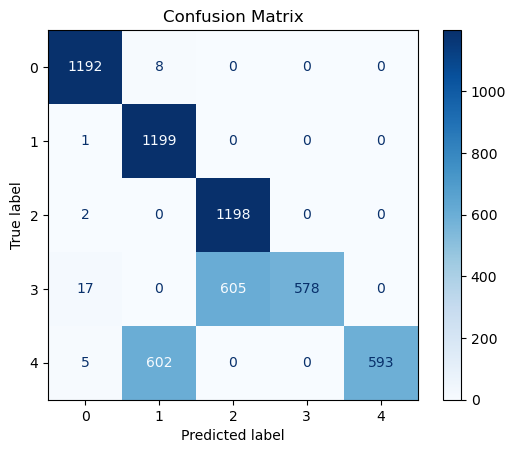

In [341]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 2 Layers

In [344]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(10500,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))


# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 53s 149ms/step - accuracy: 0.3544 - loss: 7.3287 - val_accuracy: 0.4043 - val_loss: 1.2562
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 54s 155ms/step - accuracy: 0.3892 - loss: 1.2748 - val_accuracy: 0.3971 - val_loss: 1.2450
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 56s 158ms/step - accuracy: 0.3858 - loss: 1.2668 - val_accuracy: 0.3968 - val_loss: 1.2423
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 56s 159ms/step - accuracy: 0.4016 - loss: 1.2537 - val_accuracy: 0.3971 - val_loss: 1.2410
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 55s 157ms/step - accuracy: 0.3882 - loss: 1.2813 - val_accuracy: 0.3971 - val_loss: 1.2409
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 56s 161ms/step - accuracy: 0.3821 - loss: 1.2754 - val_accuracy: 0.3971 - val_loss: 1.2410
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 56s 161ms/step - accuracy: 0.3844 - loss: 1.2904 - val_accuracy: 0.3971 - val_loss: 1.2411
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 56s 159ms/step - accuracy: 0.3611 - loss: 1

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step


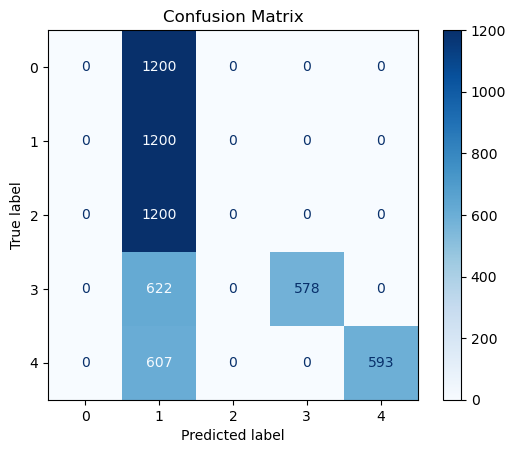

In [346]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 1 Layer Run

In [349]:
# Define the 1D CNN Model

model = Sequential()

# Add 1 convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(10500,1)))
model.add(MaxPooling1D(pool_size=2))


# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 100ms/step - accuracy: 0.3489 - loss: 12.1842 - val_accuracy: 0.4046 - val_loss: 1.2556
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 102ms/step - accuracy: 0.3958 - loss: 1.2822 - val_accuracy: 0.3971 - val_loss: 1.2450
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.3918 - loss: 1.2659 - val_accuracy: 0.3968 - val_loss: 1.2420
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.3928 - loss: 1.2649 - val_accuracy: 0.3964 - val_loss: 1.2417
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 34s 98ms/step - accuracy: 0.3922 - loss: 1.2615 - val_accuracy: 0.3971 - val_loss: 1.2411
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.3866 - loss: 1.2720 - val_accuracy: 0.3971 - val_loss: 1.2417
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 36s 101ms/step - accuracy: 0.3842 - loss: 1.2789 - val_accuracy: 0.3971 - val_loss: 1.2407
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - accuracy: 0.3881 - loss: 1.

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step


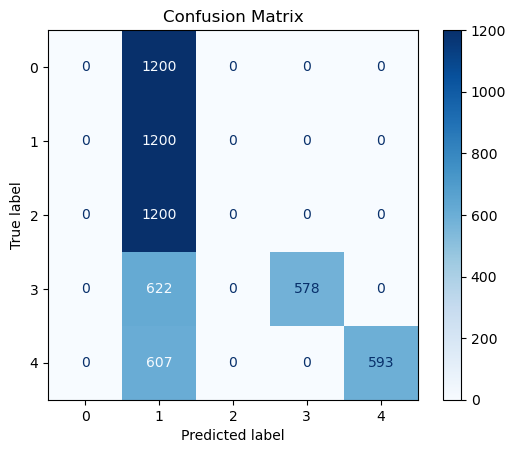

In [351]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 500 Hz Model Run

### 3 Layers

In [354]:
X = wave_500.T.values
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

(20000, 5250, 1)

In [355]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify = y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (14000, 5250, 1), y_train shape: (14000, 5)
X_test shape: (6000, 5250, 1), y_test shape: (6000, 5)


In [356]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(5250,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 106ms/step - accuracy: 0.3520 - loss: 3.0213 - val_accuracy: 0.6254 - val_loss: 0.8574
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - accuracy: 0.4930 - loss: 1.0279 - val_accuracy: 0.7571 - val_loss: 0.7257
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 106ms/step - accuracy: 0.5066 - loss: 0.9863 - val_accuracy: 0.6743 - val_loss: 0.6231
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.5325 - loss: 0.9651 - val_accuracy: 0.7968 - val_loss: 0.6344
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.5427 - loss: 0.9479 - val_accuracy: 0.7993 - val_loss: 0.6438
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 107ms/step - accuracy: 0.5457 - loss: 0.9355 - val_accuracy: 0.7989 - val_loss: 0.6022
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.5373 - loss: 0.9561 - val_accuracy: 0.8004 - val_loss: 0.5936
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 38s 109ms/step - accuracy: 0.5378 - loss: 0

188/188 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step


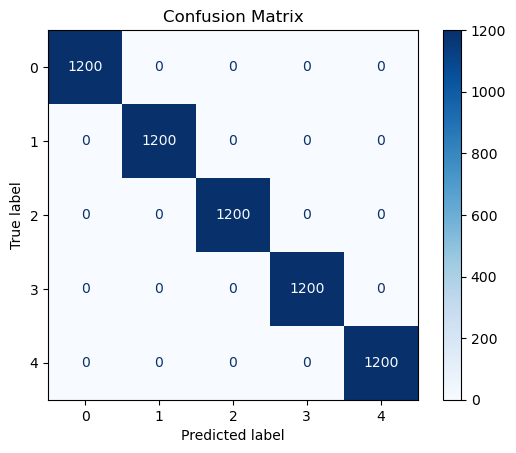

In [357]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 2 Layers

In [359]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(5250,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 70ms/step - accuracy: 0.3450 - loss: 4.3633 - val_accuracy: 0.3971 - val_loss: 1.2575
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.3945 - loss: 1.2726 - val_accuracy: 0.3971 - val_loss: 1.2455
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.3966 - loss: 1.2614 - val_accuracy: 0.3971 - val_loss: 1.2420
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.3789 - loss: 1.2844 - val_accuracy: 0.3971 - val_loss: 1.2411
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.3706 - loss: 1.3019 - val_accuracy: 0.3971 - val_loss: 1.2407
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 74ms/step - accuracy: 0.3735 - loss: 1.2862 - val_accuracy: 0.3971 - val_loss: 1.2408
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.3849 - loss: 1.2857 - val_accuracy: 0.3971 - val_loss: 1.2407
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 26s 75ms/step - accuracy: 0.3924 - loss: 1.2752 - 

188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step


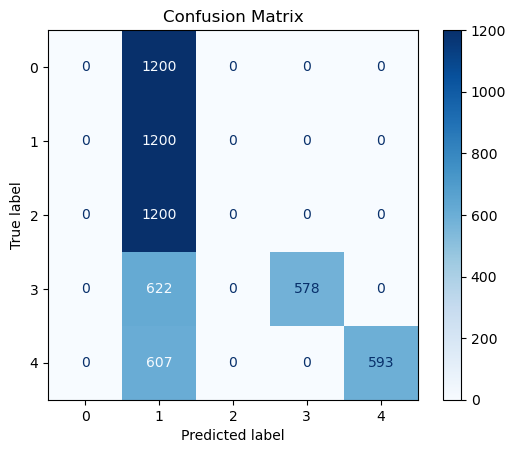

In [360]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 1 Layer

In [362]:
# Define the 1D CNN Model

model = Sequential()

# Add 1 convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(5250,1)))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.3575 - loss: 6.0826 - val_accuracy: 0.3968 - val_loss: 1.2562
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.4011 - loss: 1.2669 - val_accuracy: 0.3971 - val_loss: 1.2447
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 48ms/step - accuracy: 0.3878 - loss: 1.2674 - val_accuracy: 0.3971 - val_loss: 1.2421
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.3707 - loss: 1.2968 - val_accuracy: 0.3971 - val_loss: 1.2416
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.3824 - loss: 1.2931 - val_accuracy: 0.3957 - val_loss: 1.2471
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.3602 - loss: 1.3419 - val_accuracy: 0.3971 - val_loss: 1.2416
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.3587 - loss: 1.3255 - val_accuracy: 0.3971 - val_loss: 1.2422
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - accuracy: 0.3698 - loss: 1.3166 - 

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


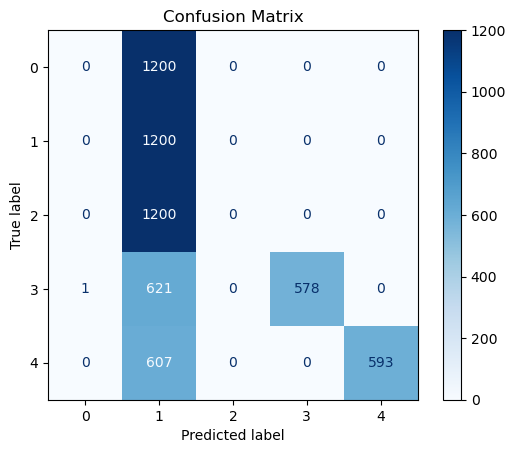

In [363]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 250 Hz Run

In [365]:
X = wave_250.T.values
X = X.reshape((X.shape[0], X.shape[1], 1))
X.shape

(20000, 1750, 1)

In [366]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify = y)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (14000, 1750, 1), y_train shape: (14000, 5)
X_test shape: (6000, 1750, 1), y_test shape: (6000, 5)


### 3 Layers

In [368]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1750,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.6233 - loss: 1.1778 - val_accuracy: 1.0000 - val_loss: 0.0377
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9445 - loss: 0.1384 - val_accuracy: 0.9946 - val_loss: 0.0269
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9589 - loss: 0.1203 - val_accuracy: 1.0000 - val_loss: 7.0546e-04
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9760 - loss: 0.0731 - val_accuracy: 1.0000 - val_loss: 4.8487e-04
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9835 - loss: 0.0483 - val_accuracy: 1.0000 - val_loss: 7.2449e-04
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9863 - loss: 0.0443 - val_accuracy: 1.0000 - val_loss: 0.0022
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.9848 - loss: 0.0456 - val_accuracy: 1.0000 - val_loss: 1.6852e-05
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.9792 -

188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step


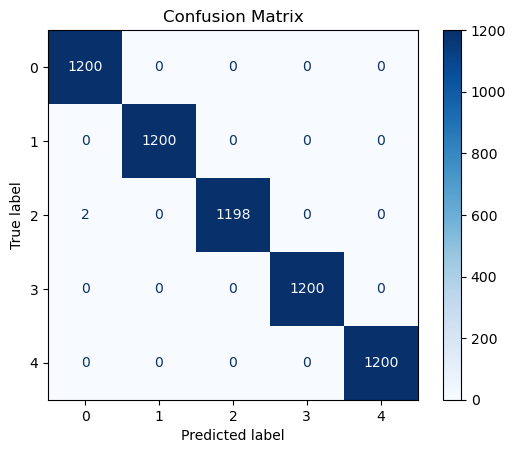

In [369]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 2 Layers

In [371]:
# Define the 1D CNN Model

model = Sequential()

# Add 3 convolutional layers
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1750,1)))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.4629 - loss: 2.3513 - val_accuracy: 0.8936 - val_loss: 0.4811
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 26ms/step - accuracy: 0.7198 - loss: 0.6452 - val_accuracy: 0.9929 - val_loss: 0.1740
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7274 - loss: 0.5858 - val_accuracy: 0.9911 - val_loss: 0.1600
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7212 - loss: 0.5290 - val_accuracy: 0.9911 - val_loss: 0.0857
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.7474 - loss: 0.4876 - val_accuracy: 0.9986 - val_loss: 0.0824
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7510 - loss: 0.4881 - val_accuracy: 0.9989 - val_loss: 0.0317
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - accuracy: 0.7620 - loss: 0.4768 - val_accuracy: 0.9989 - val_loss: 0.0410
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step - accuracy: 0.7726 - loss: 0.4619 - val_accuracy: 0

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


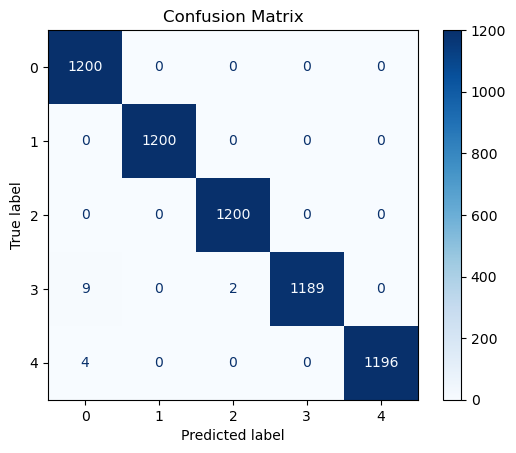

In [372]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### 1 Layer

In [374]:
# Define the 1D CNN Model

model = Sequential()

# Add 1 convolutional layer
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(1750,1)))
model.add(MaxPooling1D(pool_size=2))

# Flatten and add dense layers
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 3 classes
model.add(Dense(5, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

Epoch 1/20


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3606 - loss: 4.2098 - val_accuracy: 0.4089 - val_loss: 1.2604
Epoch 2/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.3836 - loss: 1.2916 - val_accuracy: 0.3971 - val_loss: 1.2446
Epoch 3/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - accuracy: 0.3921 - loss: 1.2595 - val_accuracy: 0.3971 - val_loss: 1.2419
Epoch 4/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.3987 - loss: 1.2537 - val_accuracy: 0.3971 - val_loss: 1.2411
Epoch 5/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - accuracy: 0.3949 - loss: 1.2645 - val_accuracy: 0.3971 - val_loss: 1.2411
Epoch 6/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.3798 - loss: 1.2751 - val_accuracy: 0.3971 - val_loss: 1.2410
Epoch 7/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 13s 37ms/step - accuracy: 0.3699 - loss: 1.2823 - val_accuracy: 0.3971 - val_loss: 1.2417
Epoch 8/20
350/350 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - accuracy: 0.3702 - loss: 1.2974 - val_accuracy: 0.39

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


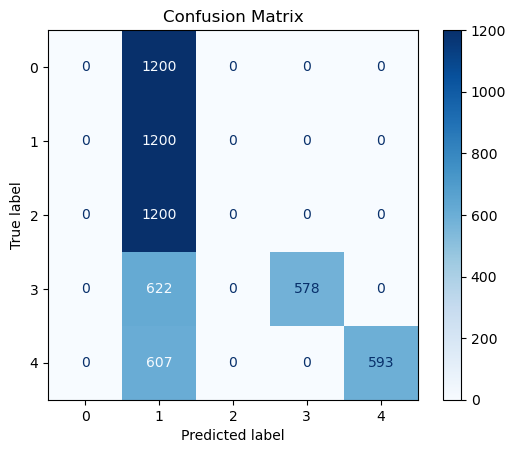

In [375]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

if y_test.ndim == 1:
    y_true = y_test
else:
    y_true = np.argmax(y_test, axis=1)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

### GradCAM Implementation